Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive
--2023-11-13 20:59:40--  https://storage.googleapis.com/storage.barbiero.dev/public_data_clean_balanced_splitted.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229962973 (219M) [application/octet-stream]
Saving to: ‘public_data_clean_balanced_splitted.npz.6’

public_data_clean_b 100%[===================>] 219.31M  12.3MB/s    in 20s     

2023-11-13 21:00:02 (11.0 MB/s) - ‘public_data_clean_balanced_splitted.npz.6’ saved [229962973/229962973]

0 input_2 True
1 convnext_base True
2 global_average_pooling2d True
3 dense True
4 dropout True
5 dense_1 True
Epoch 1/200
139/139 [==============================] - 119s 355ms/step - loss: 0.5340 -

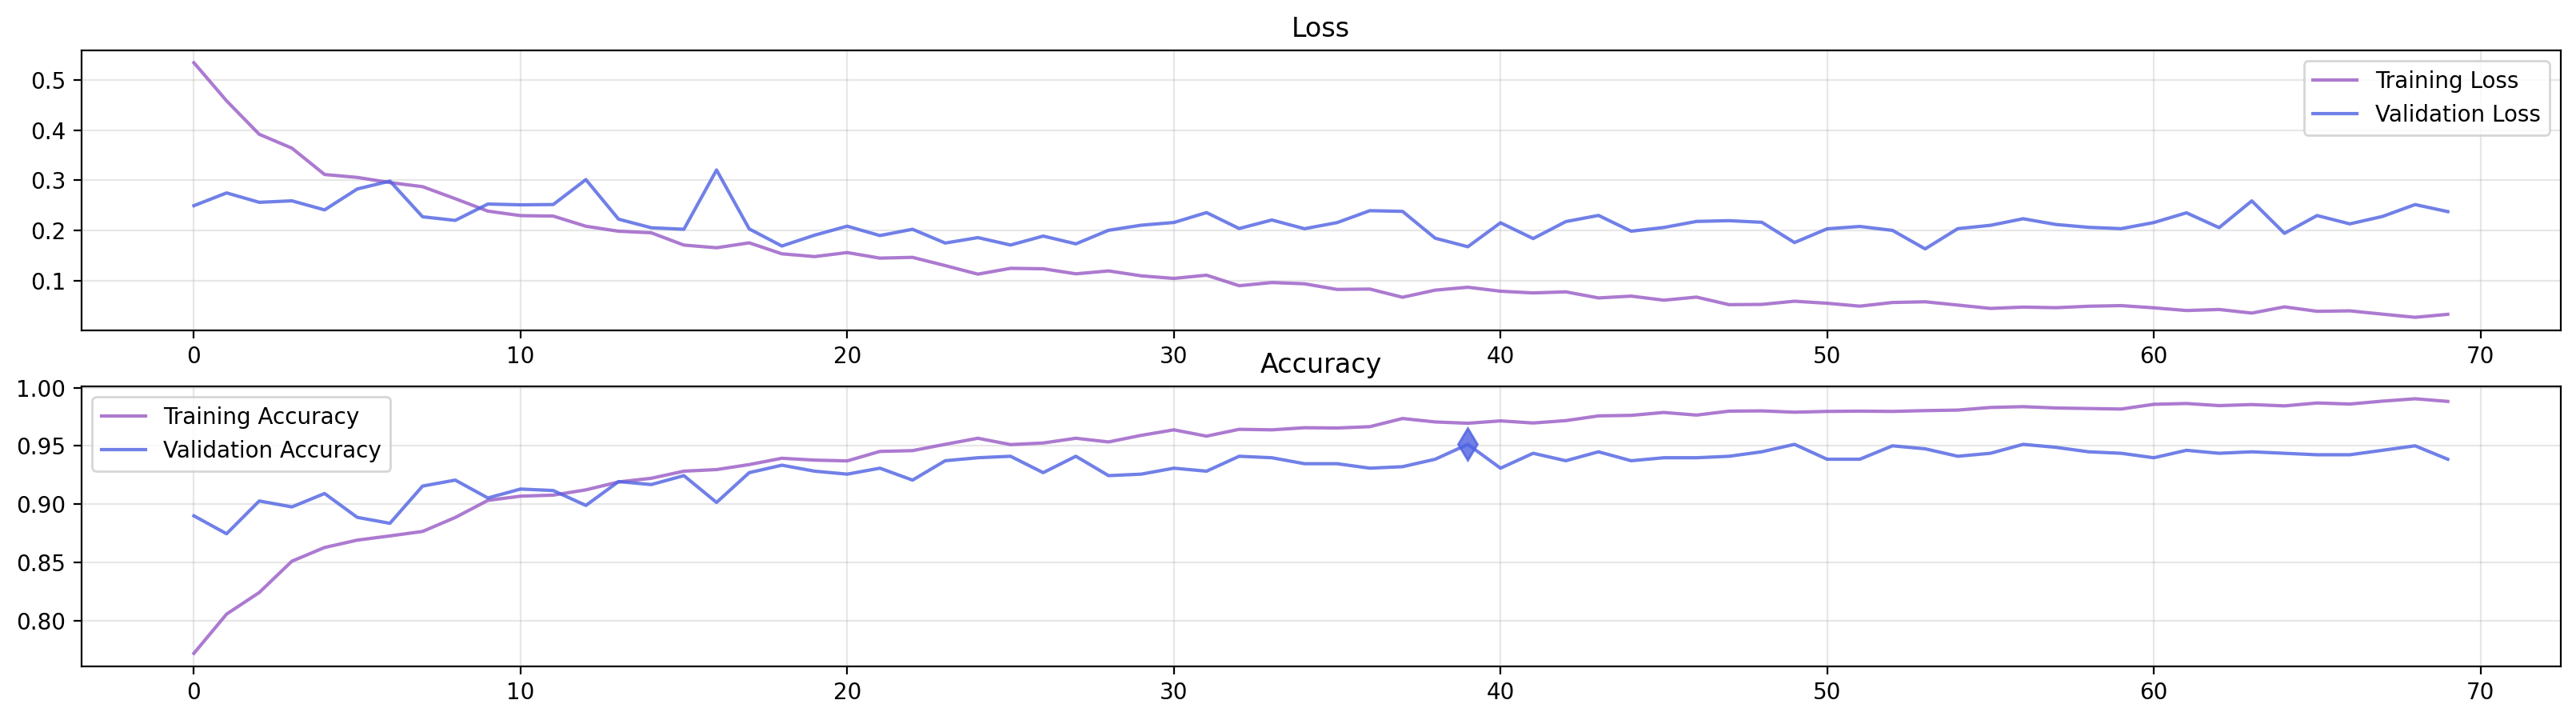

Accuracy Score over the Test Set: 0.939

Accuracy: 0.939
Precision: 0.939
Recall: 0.939
F1: 0.939


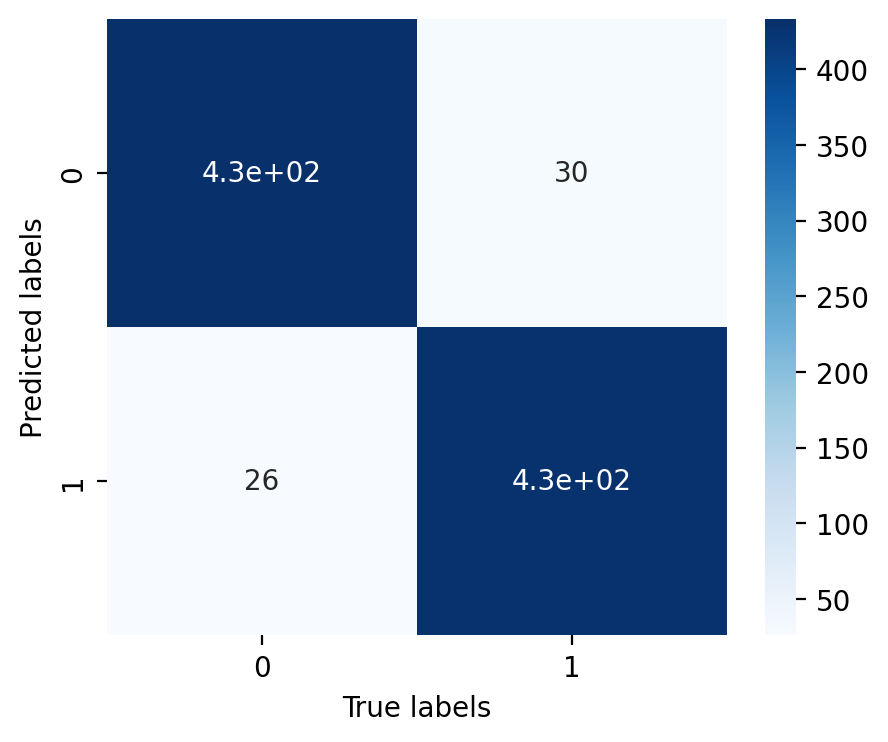

In [7]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive


import os
import logging
import warnings as wr
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras as tfk
from keras import layers as tfkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Random Configuration - All
RND = True
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Plotting Functions
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()

def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")


!wget https://storage.googleapis.com/storage.barbiero.dev/public_data_clean_balanced_splitted.npz


X_train_val, y_train_val, X_test, y_test = np.load('public_data_clean_balanced_splitted.npz', allow_pickle=True).values()

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 0.15,
    **({"random_state":SEED} if not RND else {}),
    stratify = y_train_val,
    random_state = 123
)

X_train = X_train.astype("float32")
X_val = X_val.astype("float32")
X_test = X_test.astype("float32")

y_train = tfk.utils.to_categorical(y_train,len(np.unique(y_train)))
y_val = tfk.utils.to_categorical(y_val,len(np.unique(y_val)))
y_test = tfk.utils.to_categorical(y_test,len(np.unique(y_test)))

input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

def build_model(inpu,output):
  # MODEL HERE
  preprocessing = tfk.Sequential([
        tfkl.RandomTranslation(height_factor=(-0.3,0.3),width_factor=(-0.3,0.3)),
        tfkl.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2)),
        tfkl.RandomFlip('horizontal'),
        tfkl.RandomRotation(factor=359)
      ], name='preprocessing'
    )
  model = tfk.models.load_model("/gdrive/My Drive/MixUp_ConvNeXt_2")

  model.get_layer('convnext_base').trainable = True
  model.trainable = True

  for i, layer in enumerate(model.get_layer('convnext_base').layers[:200]):
    layer.trainable=False

  input_layer = tfkl.Input(input_shape)
  x = preprocessing(input_layer)
  model = model(x)
  model =tfk.Model(input_layer, model)

  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Nadam(learning_rate=0.0001, weight_decay=0.001), metrics=['accuracy'])

  return model


model = build_model(input_shape,output_shape)


# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                         # Metric to monitor (validation mean squared error in this case)
    patience=5,                                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.85,                                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                                     # Minimum learning rate
)

callbacks = [early_stopping,lr_scheduler]

history = model.fit(
    X_train,
    y_train,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

plot_losses(history, (20,5), "aa")

test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_gt = np.argmax(y_test, axis=-1)
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
print()

# Compute the confusion matrix
test_predictions = model.predict(X_test, verbose=0)
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(5, 4), dpi=200)
sns.heatmap(cm.T, annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()


In [8]:
model.save("/gdrive/My Drive/MixUp_ConvNeXt_3_MixedFT")